# Integrate DataRobot and Snowpark by maximizing the data cloud

Author: Atalia Horenshtien

Version Date: April 6 2023

## Overview

This notebook showcases the native integration between DataRobot and Snowflake's data cloud, leveraging DataRobot notebooks and Snowflake Snowpark (with Python and Java).

### DataRobot
The notebook leverages DataRobot ML experimentation. DataRobot hosts notebooks, AutoML, model selection, insights and explainability, and ML production as a single shop for deployment and model monitoring.

### Snowflake
You will leverage Snowflake for data storage and Snowpark for deployment, feature engineering, and model scoring. They facilitate data source access and utilize the Spark's backbone to perform distributed scoring to support large-scale use cases.

The dataset for this project is a fraud detection use case and the notebook was created from a DataRobot notebook. DataRobot notebooks are Jupyter compatible and supporting preloaded packages for Python and R. DataRobot notebooks can also be used for code-snippets, versioning, and simple environment management for rapid AI experimentation to increase your productivity.

### Summary

This notebook covers the following steps:

1. Load data to Snowflake from an S3 file
2. Acquire a training dataset from a Snowflake table using Snowpark for Python
3. Feature engineering: analyze data and create new features using Snowpark
4. Build a new DataRobot project
5. Analyze and evaluate model performance and explainability using DataRobot AutoML
6. Deploy the recommended model to Snowflake using DataRobot MLOps
7. Score the model via Snowpark for Java
8. Monitor the model with MLOps

## Setup

Before executing the cells in the notebook, ensure the following:

* Make sure the environment is Python 3.8
* Configure the following environmental variables (with your own Snowflake credentials):
    'snowflake_user' - Snowflake user name
    'snowflake_password' - Snowflake password
    'snowflake_account' - Snowflake account name

Most of this workflow is executed by the notebook, but you will create a deployment and monitor it via the DataRobot GUI. Supporting documentation for these steps are included the notebook.

In [1]:
# If needed, install the following:
!pip install Flask-SQLAlchemy
!pip install --upgrade snowflake-sqlalchemy

     |████████████████████████████████| 624kB 82.1MB/s 


     |████████████████████████████████| 1.6MB 36.2MB/s 


  Found existing installation: SQLAlchemy 2.0.9


    Uninstalling SQLAlchemy-2.0.9:
      Successfully uninstalled SQLAlchemy-2.0.9


### Import libraries

In [ ]:
import datetime as datetime
from datetime import datetime
import json
import os
from pathlib import Path

from datarobot.enums import CHART_DATA_SOURCE, DATA_DRIFT_METRIC
from datarobot.models.deployment import Deployment, FeatureDrift
from datarobot.models.prediction_server import PredictionServer
from datarobot.models.project import Project
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import snowflake.connector
from snowflake.connector.pandas_tools import pd_writer
from snowflake.snowpark import Session
from snowflake.snowpark.functions import call_udf, col, udf
from sqlalchemy import create_engine
from sqlalchemy.dialects import registry

# from datarobot.models import FeatureDrift


registry.register("snowflake", "snowflake.sqlalchemy", "dialect")
import urllib.parse

from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

### Bind data source credentials

In [ ]:
snowflake_password = os.environ["snowflake_password"]
snowflake_user = os.environ["snowflake_user"]
snowflake_account = os.environ["snowflake_account"]

In [ ]:
# No need to change these bindings as they are for the demo workflow

database_name = "SANDBOX"
schema_name = "FINANCE"
warehouse_name = "DEMO_WH"

### Import data

Use the following cell to load training data for the sample workflow: importing the "Fraud Detection" dataset from S3 to Snowflake.

In [5]:
# load training data - 'Fraud Detection' from S3 to Snowflake
safe_password_string = urllib.parse.quote_plus(snowflake_password)

conn_string = f"snowflake://{snowflake_user}:{safe_password_string}@{snowflake_account}/{database_name}"

engine = create_engine(conn_string)

# %%

engine.execute(
    """
    CREATE SCHEMA IF NOT EXISTS FINANCE;
    
    
    """
)

renamer = {"date": "DATE_COLUMNS"}
pd.read_csv(
    "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/FRAUD_DETECTION_TRAINING.csv"
).rename(columns=renamer).to_sql(
    name="fraud_detection_training",
    schema=schema_name,
    con=engine,
    if_exists="replace",
    method=pd_writer,
    index=False,
)


# %

/tmp/ipykernel_25/4281520494.py:12: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  engine.execute(


In [ ]:
CONNECTION_PARAMETERS = {
    "account": snowflake_account,
    "user": snowflake_user,
    "password": snowflake_password,
    "database": database_name,
    "schema": schema_name,
    "warehouse": warehouse_name,
}

### Data Preparation 

This workflow uses Snowpark for feature engineering. Snowpark is a developer framework where you can work in a familiar syntax such as Python. Snowpark pushes down processing to Snowflake to run consistently in a highly secure and elastic engine.

In [ ]:
# Create the ‘session’ object that represents Snowpark and a dataframe that references the data in Snowflake

session = Session.builder.configs(CONNECTION_PARAMETERS).create()

In [ ]:
df_train = session.table("FRAUD_DETECTION_TRAINING")

In [9]:
df_train.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ISFRAUD"  |"TRNX_ID"   |"CITY"         |"SHIPPING_ZIPCODE"  |"SHIPPING_STATE"  |"IS_OVERNIGHT_SHIPPING"  |"PAYMENT_NETWORK"  |"PAYMENT_TYPE"  |"AVG_TRNX_AMOUNT_PER_ITEM"  |"TOTAL_TRNX_AMOUNT"  |"PROMO_CODE"  |"GUEST_CHECKOUT"  |"ACCOUNT_CHECKOUT"  |"IS_NIGHT_ORDER"  |"EMAIL_ON_FILE"  |"SESSION_LENGTH_IN_MINS"  |"COOKIE_IS_SEEN_BEFORE"  |"IS_BROWSER_LANGUAGE_TRANSLATED"  |"l_6KhI_IP_ADDRESS"    |"CSRNOTES"                                          |"r_torw_IP_ADDR

In [ ]:
# Snowpark - Create an instance of UserDefinedFunction using the @udf decorator


@udf
# Define the function arguments: WHOLE_WEIGHT, HEIGHT
def is_long_session(session_length_in_mins: float) -> bool:
    if session_length_in_mins > 20:
        return 1
    else:
        return 0

In [ ]:
# Snowpark call UDFs on a dataframe, with calculation in Snowflake
udf_df_train = df_train.select(
    col("*"), is_long_session(col("SESSION_LENGTH_IN_MINS")).alias("LONG_SESSION")
)

In [ ]:
udf_df_train.write.mode("overwrite").save_as_table("FRAUD_DETECTION_TRAINING")

In [ ]:
# Snowpark supports Pandas
df_train_pd = df_train.toPandas()

<AxesSubplot: xlabel='ISFRAUD', ylabel='count'>

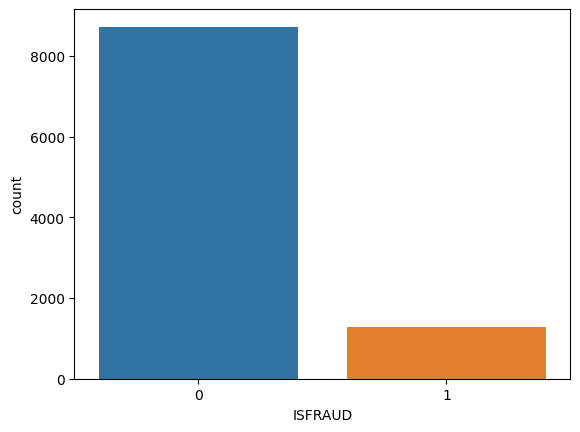

In [14]:
sns.countplot(data=df_train_pd, x="ISFRAUD")

## Modeling

In this section you'll leverage DataRobot’s AutoML capabilities, including explainability and compliance documentation to speed up the model’s results and regulatory compliance.

In [ ]:
# Optional - If you've already run Autopilot before, get the project by replacing the ID
# project = Project.get('63853765cfc79e4555fa2537')

In [ ]:
# Define the project name and current date
now = datetime.now().strftime("%Y-%m-%dT%H:%M")
project = Project.create(df_train_pd, project_name="Fraud_detection_{}".format(now))

### Start Autopilot

In [ ]:
# Set the target variable and start Autopilot
project.analyze_and_model(
    target="ISFRAUD",  # setting project target
    mode="quick",  # setting up project run mode, leaving in auto
    worker_count=-1,  # assigning worker count, -1 will use all available
    max_wait=24
    * 60
    * 60,  # time series projects can take a little more time to get through EDA2 than normal AutoML projects
)

In [ ]:
# This (optional) will block execution of the notebook until the full autopilot process has completed. This can take several minutes or hours, depending on the autopilot mode selected, the size of the dataset, and the type of problem we're trying to solve.

project.wait_for_autopilot()

In [16]:
# This output a list of all the models trained in the project, sorted by the selected validation metric.

project.get_models()[:10]

[Model('Light Gradient Boosted Trees Classifier with Early Stopping'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping'),
 Model('AVG Blender'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping'),
 Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping with Bias Mitigation Reweighing using CITY (excluded as predictor variable)'),
 Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping'),
 Model('Elastic-Net Classifier (L2 / Binomial Deviance)'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping')]

### Get the most accurate model

DataRobot provides a recommendation for an accurate and well-performing model at the end of training process.

In [ ]:
# Get the most accurate model based on the project's metric
most_accurate_model = project.get_top_model()

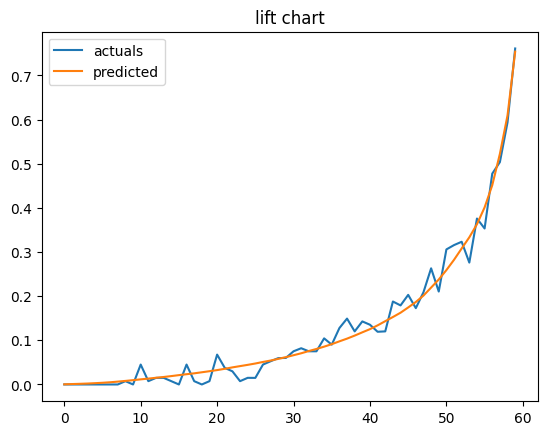

In [18]:
# Evaluate the model using a lift chart
plot = most_accurate_model.get_lift_chart("crossValidation")
df = pd.DataFrame.from_dict(plot.bins)

# Create data
x = df.index
y = df["actual"]
y2 = df["predicted"]

# Plot lines
plt.plot(x, y, label="actuals")
plt.plot(x, y2, label="predicted")
plt.legend()
plt.title("lift chart")
plt.show()

(0.0, 1.0)

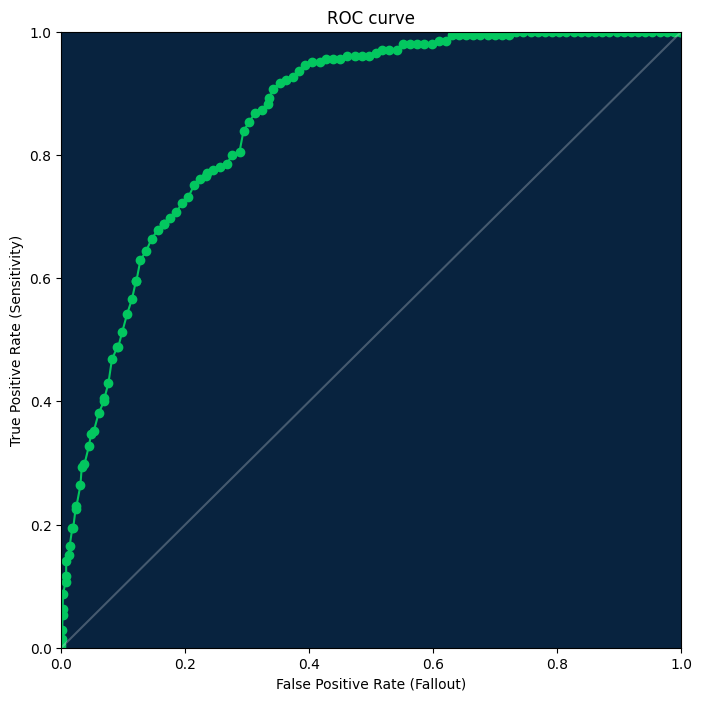

In [19]:
# Evaluate the model using ROC Curve

# Get the ROC curve
roc = most_accurate_model.get_roc_curve(source=CHART_DATA_SOURCE.VALIDATION)

# Save the result into a Pandas dataframe
roc_df = pd.DataFrame(roc.roc_points)
roc_df.head()

# Set chart colors
dr_roc_green = "#03c75f"
white = "#ffffff"
dr_purple = "#65147D"
dr_dense_green = "#018f4f"
dr_dark_blue = "#08233F"

# Create chart
fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(1, 1, 1, facecolor=dr_dark_blue)
plt.scatter(roc_df.false_positive_rate, roc_df.true_positive_rate, color=dr_roc_green)
plt.plot(roc_df.false_positive_rate, roc_df.true_positive_rate, color=dr_roc_green)
plt.plot([0, 1], [0, 1], color=white, alpha=0.25)

# Format chart
plt.title("ROC curve")
plt.xlabel("False Positive Rate (Fallout)")
plt.xlim([0, 1])
plt.ylabel("True Positive Rate (Sensitivity)")
plt.ylim([0, 1])

<AxesSubplot: xlabel='featureName', ylabel='impactNormalized'>

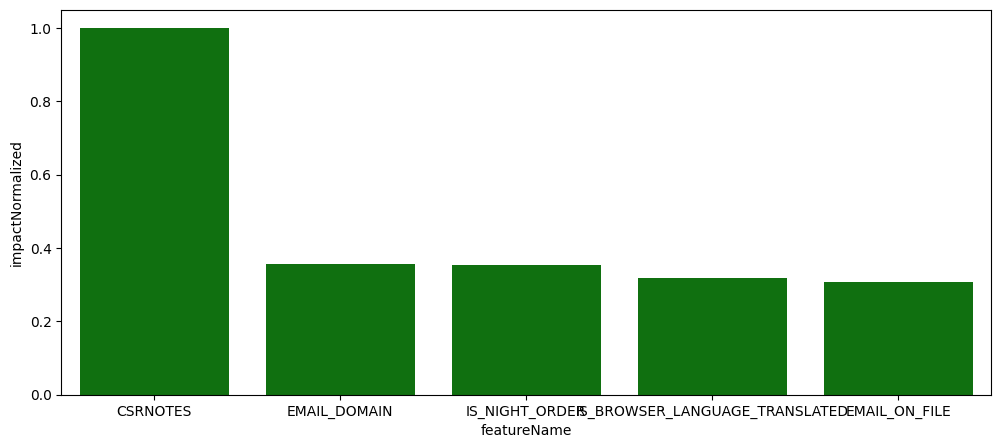

In [20]:
# Get insights on which feature driving model's outcome

# Get Feature Impact
feature_impact = most_accurate_model.get_or_request_feature_impact()

# Save Feature Impact in a Pandas dataframe
fi_df = pd.DataFrame(feature_impact)

# Plot the top five most impactful features
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="featureName", y="impactNormalized", data=fi_df[0:5], color="g")

## Model Deploymnet

To deploy to Snowflake, you need to do it through the DataRobot GUI. Reference the documentation to [create a snowflake prediction environment and deployment](https://docs.datarobot.com/en/docs/mlops/mlops-preview/pp-snowflake-sc-deploy-replace.html).

In [21]:
# Get the deployed model and change the ID to your deployment's
deployment = Deployment.get("6413a07ea0a9ee22d203464b")
deployment

Deployment(ISFRAUD Predictions)

In [22]:
# Create the scoring data
# This workflow uses an example for subset data
query = (
    " create or replace table FRAUD_DETECTION_SCORING as "
    + "  select * from FRAUD_DETECTION_TRAINING limit 10 "
)

session.sql(query).collect()

[Row(status='Table FRAUD_DETECTION_SCORING successfully created.')]

In order to score the data in Snowflake, leverage Snowpark for Java.

Go to the created deployment's **Predictions** tab. Copy the signature of the function included there and replace it in the next section. 

Example:
query = " SELECT *, scoring_code_udf_schema.replace_function_name_here(OBJECT_CONSTRUCT_KEEP_NULL(*)) " +\
        " FROM FRAUD_DETECTION_SCORING "

In [23]:
# Score new data

query = (
    " CREATE OR REPLACE TABLE FRAUD_DETECTION_SCORING as"
    + " SELECT *, datarobot_deployment_642adf008b22ed8d5de483ba(OBJECT_CONSTRUCT_KEEP_NULL(*)) as model_score FROM FRAUD_DETECTION_SCORING;"
)


session.sql(query).collect()

[Row(status='Table FRAUD_DETECTION_SCORING successfully created.')]

In [24]:
# Store results and modify column names

query = ' CREATE OR REPLACE TABLE FRAUD_DETECTION_SCORING as select *, model_score:"0"::float false_fraud, model_score:"1"::float true_fraud  from FRAUD_DETECTION_SCORING; '

session.sql(query).collect()

[Row(status='Table FRAUD_DETECTION_SCORING successfully created.')]

In [25]:
# Convert the session object to a dataframe

df_scored = session.table("FRAUD_DETECTION_SCORING")
df_scored_pd = df_scored.toPandas()
df_scored_pd

,ISFRAUD,TRNX_ID,CITY,SHIPPING_ZIPCODE,SHIPPING_STATE,IS_OVERNIGHT_SHIPPING,PAYMENT_NETWORK,PAYMENT_TYPE,AVG_TRNX_AMOUNT_PER_ITEM,TOTAL_TRNX_AMOUNT,...,SESSION_LENGTH_IN_MINS,COOKIE_IS_SEEN_BEFORE,IS_BROWSER_LANGUAGE_TRANSLATED,l_6KhI_IP_ADDRESS,CSRNOTES,r_torw_IP_ADDRESS,EMAIL_DOMAIN,NUMBER_SESSION_FROM_IP_PAST_24HR,IS_LONG_SESSION,PREDICTED_fraud
0,0,00JAVY6847,Cedar Rapids,52406,IA,FALSE,Mastercard,Credit,94.139284,282.42,...,10.0,FALSE,FALSE,113.73.30.88,"returned customer, customer forgot password du...",113.73.30.88,aol.com,1,False,"{\n ""0"": ""0.9987761053302698"",\n ""1"": ""0.001..."
1,0,0APR62D0SS,Grand Bay,36541,AL,FALSE,Diners Club,Credit,26.380558,79.14,...,15.0,FALSE,FALSE,97.112.207.90,,97.112.207.90,att.net,1,False,"{\n ""0"": ""0.9769267191355263"",\n ""1"": ""0.023..."
2,0,01JKZ195MD,Weatherford,76086,TX,FALSE,Mastercard,Credit,22.707657,68.12,...,24.0,FALSE,FALSE,108.224.62.62,,108.224.62.62,outlook.com,1,True,"{\n ""0"": ""0.9090399735033318"",\n ""1"": ""0.090..."
3,0,0BEU88OL9H,Minneapolis,55440,MN,FALSE,Mastercard,Credit,32.434132,97.30,...,17.0,FALSE,FALSE,63.159.152.5,,63.159.152.5,outlook.com,0,False,"{\n ""0"": ""0.9763719916143826"",\n ""1"": ""0.023..."
4,0,02PNVHW13B,Gloversville,12078,NY,TRUE,Amex,Credit,19.878665,99.39,...,12.0,FALSE,FALSE,2600:380:a6ae:c00::,"refund request, refund request,",2600:380:a6ae:c00::,hotmail.com,0,False,"{\n ""0"": ""0.9971434045612121"",\n ""1"": ""0.002..."
5,0,03NK9AU52E,Estral Beach,48166,MI,FALSE,Amex,Credit,33.222896,66.45,...,15.0,FALSE,FALSE,174.25.128.220,,174.25.128.220,outlook.com,0,False,"{\n ""0"": ""0.9335619103828412"",\n ""1"": ""0.066..."
6,0,04W04DJM5T,Redmond,98052,WA,FALSE,Mastercard,Credit,71.395618,285.58,...,16.0,FALSE,FALSE,42.230.81.104,,42.230.81.104,yahoo.co.uk,0,False,"{\n ""0"": ""0.8584359395435129"",\n ""1"": ""0.141..."
7,0,06JITFOD1N,Elizabethtown,42702,KY,FALSE,Mastercard,Credit,69.751634,139.50,...,12.0,FALSE,FALSE,75.117.219.68,,75.117.219.68,gmail.com,0,False,"{\n ""0"": ""0.9905605724847669"",\n ""1"": ""0.009..."
8,1,08ALVFF4FR,Springfield,65802,MO,FALSE,Mastercard,Credit,50.836736,152.51,...,14.0,FALSE,FALSE,2.68.243.18,,2.68.243.18,att.net,0,False,"{\n ""0"": ""0.8376832715457245"",\n ""1"": ""0.162..."
9,0,09J3O32I0B,Corpus Christi,78427,TX,FALSE,Amex,Credit,64.471699,128.94,...,16.0,TRUE,TRUE,75.87.63.240,,75.87.63.240,gotmail.net,1,False,"{\n ""0"": ""0.7116289224625789"",\n ""1"": ""0.288..."


You can see the predictions in the last two columns.

## Model monitoring

To make sure business decisions are aligned with external and internal factors, monitor the model performance and understand if the model needs to be replaced or retrained. To learn how to define a monitoring job, [reference the documentation](https://docs.datarobot.com/en/docs/mlops/mlops-preview/pp-monitoring-jobs.html).

Once the monitoring job is executed, you can see data drift and accuracy in the UI or retrieve it with the API.

In [26]:
# Get target drift

target_drift = deployment.get_target_drift(
    start_time=datetime(2023, 4, 1, hour=15), end_time=datetime(2023, 4, 4, hour=15)
)
target_drift.drift_score

8.162262704563577

## Conclusion and next steps

DataRobot and Snowflake together offer an end-to-end, enterprise-grade AI experience and expertise to enterprises by reducing complexity and productionizing ML models at scale, unlocking business value.

[Visit the DataRobot website](https://www.datarobot.com/partners/technology-partners/snowflake/) to learn more.